In [32]:
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
from PIL import Image
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# training images

In [3]:
data_folder = 'images/images/train'  
image_size = (148,148)  
subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
image_train=[]
train_label = [] 
for subfolder in tqdm(subfolders):
    label = os.path.basename(subfolder)  
    for file in os.listdir(subfolder):
        file_path = os.path.join(subfolder, file)
        image = cv2.imread(file_path)
        image = cv2.resize(image, image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_train.append(image)
        train_label.append(label)
image_train=np.array(image_train)
train_label=np.array(train_label)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:14<00:00,  2.08s/it]


# validation images

In [4]:
data_folder = 'images/images/validation'  
image_size = (48,48)  
subfolders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
image_val=[]
val_label = [] 
for subfolder in tqdm(subfolders):
    label = os.path.basename(subfolder)  
    for file in os.listdir(subfolder):
        file_path = os.path.join(subfolder, file)
        image = cv2.imread(file_path)
        image = cv2.resize(image, image_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_val.append(image)
        val_label.append(label)
image_val=np.array(image_val)
val_label=np.array(val_label)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.33it/s]


In [5]:
image_train.shape

(28821, 148, 148)

In [6]:
image_val.shape

(7066, 48, 48)

In [7]:
image_train[1]

array([[152, 152, 151, ..., 127, 121, 121],
       [152, 152, 151, ..., 126, 121, 121],
       [151, 151, 151, ..., 130, 125, 125],
       ...,
       [186, 186, 186, ..., 184, 185, 185],
       [186, 186, 186, ..., 182, 183, 183],
       [186, 186, 185, ..., 182, 183, 183]], dtype=uint8)

In [8]:
image_train[3].shape

(148, 148)

In [9]:
np.unique(train_label,return_counts=True)

(array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype='<U8'),
 array([3993,  436, 4103, 7164, 4982, 4938, 3205], dtype=int64))

In [10]:
np.unique(val_label,return_counts=True)

(array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype='<U8'),
 array([ 960,  111, 1018, 1825, 1216, 1139,  797], dtype=int64))

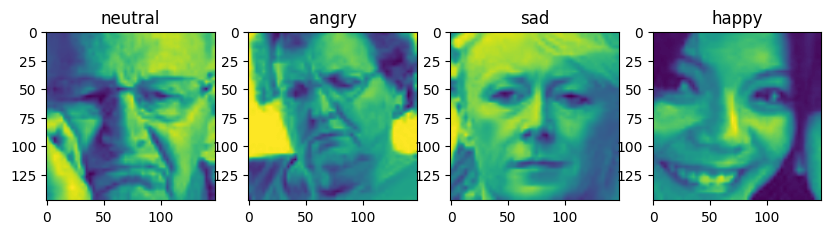

In [11]:
plt.figure(figsize=(10,4))
for i in range(1,5):
    plt.subplot(1,4,i)
    index=np.random.randint(image_train.shape[0],size=1)[0]
    plt.imshow(image_train[index])
    plt.title(train_label[index])

In [13]:
class_folders

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [14]:
image_train = image_train.astype('float32')
image_train /= 255.0
image_val = image_val.astype('float32')
image_val /= 255.0

In [15]:
image_train[6]

array([[0.13725491, 0.13725491, 0.1254902 , ..., 0.23137255, 0.24705882,
        0.24705882],
       [0.13725491, 0.13725491, 0.1254902 , ..., 0.23137255, 0.24705882,
        0.24705882],
       [0.12156863, 0.12156863, 0.11372549, ..., 0.23137255, 0.24705882,
        0.24705882],
       ...,
       [0.54901963, 0.54901963, 0.49803922, ..., 0.49803922, 0.54901963,
        0.54901963],
       [0.41568628, 0.41568628, 0.38039216, ..., 0.4745098 , 0.5254902 ,
        0.5254902 ],
       [0.41568628, 0.41568628, 0.38039216, ..., 0.4745098 , 0.5254902 ,
        0.5254902 ]], dtype=float32)

In [16]:
label_df_train=pd.DataFrame(train_label)
label_df_val=pd.DataFrame(val_label)

In [17]:
label_df_train=pd.get_dummies(label_df_train,dtype="int")
label_df_val=pd.get_dummies(label_df_val,dtype="int")

In [18]:
label_df_val.sample(5)

,0_angry,0_disgust,0_fear,0_happy,0_neutral,0_sad,0_surprise
2542,0,0,0,1,0,0,0
3688,0,0,0,1,0,0,0
851,1,0,0,0,0,0,0
3608,0,0,0,1,0,0,0
770,1,0,0,0,0,0,0


In [19]:
image_train.shape,label_df_train.shape

((28821, 148, 148), (28821, 7))

In [20]:
image_train.shape,label_df_train.shape

((28821, 148, 148), (28821, 7))

# model creation

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Add

# Define input shape for images (assuming grayscale images of size 48x48 pixels)
input_shape = (48, 48, 1)

# Input layer for images
input_layer = Input(shape=input_shape, name='input_layer')

# Initial convolutional layer
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# Residual blocks
num_blocks = 3  # Number of residual blocks
filters = 64  # Number of filters in each block

def residual_block(input_data, filters):
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(input_data)
    x = BatchNormalization()(x)
    x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([input_data, x])
    x = MaxPooling2D(pool_size=(2, 2))(x)
    return x

residual_output = pool1
for _ in range(num_blocks):
    residual_output = residual_block(residual_output, filters)

# Global average pooling layer
global_avg_pool = GlobalAveragePooling2D()(residual_output)

# Fully connected layers
fc1 = Dense(128, activation='relu')(global_avg_pool)
fc1 = Dropout(0.5)(fc1)
output_layer = Dense(7, activation='softmax')(fc1)  # Adjust num_classes based on your facial expression classes

# Define the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 48, 48, 64)           640       ['input_layer[0][0]']         
                                                                                                  
 batch_normalization_8 (Bat  (None, 48, 48, 64)           256       ['conv2d_23[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 conv2d_24 (Conv2D)          (None, 48, 48, 64)           36928     ['batch_normalization_8[0]

In [41]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # Fill mode for points outside the input boundaries
)

# Load and augment training data
train_generator = train_datagen.flow_from_directory(
    'images/images/train',  # Path to the directory containing training images
    target_size=(48, 48),  # Target size of the images (48x48 pixels)
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    color_mode='grayscale'  # Grayscale images
)

# Define validation data generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'images/images/validation',  # Path to the directory containing validation images
    target_size=(48, 48),  # Target size of the images (48x48 pixels)
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    color_mode='grayscale'  # Grayscale images
)


# Define callbacks
checkpoint_callback = ModelCheckpoint(
    'best_sentiment_model.h5',  # File to save the best model weights
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode='max',  # Save the model with the highest validation accuracy
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=6,  # Number of epochs to wait before stopping
    mode='max',  # Stop when validation accuracy stops increasing
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,  # Increase the number of epochs as needed
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.
Epoch 1/50
901/901 [==============================] - ETA: 0s - loss: 1.8728 - accuracy: 0.2397
Epoch 1: val_accuracy improved from -inf to 0.26153, saving model to best_sentiment_model.h5
901/901 [==============================] - 101s 108ms/step - loss: 1.8728 - accuracy: 0.2397 - val_loss: 1.7744 - val_accuracy: 0.2615
Epoch 2/50
901/901 [==============================] - ETA: 0s - loss: 1.7019 - accuracy: 0.3109
Epoch 2: val_accuracy improved from 0.26153 to 0.33484, saving model to best_sentiment_model.h5
901/901 [==============================] - 101s 112ms/step - loss: 1.7019 - accuracy: 0.3109 - val_loss: 1.6270 - val_accuracy: 0.3348
Epoch 3/50
901/901 [==============================] - ETA: 0s - loss: 1.5399 - accuracy: 0.3899
Epoch 3: val_accuracy improved from 0.33484 to 0.47240, saving model to best_sentiment_model.h5
901/901 [==============================] - 92s 102ms/step - loss: 1.5399

In [28]:
from tensorflow.keras.models import load_model

In [35]:
pred_dict={0:"Angry",1:"Disgust",2:"Fear",3:"Happy",4:"Normal",5:"Sad",6:"suprise"}

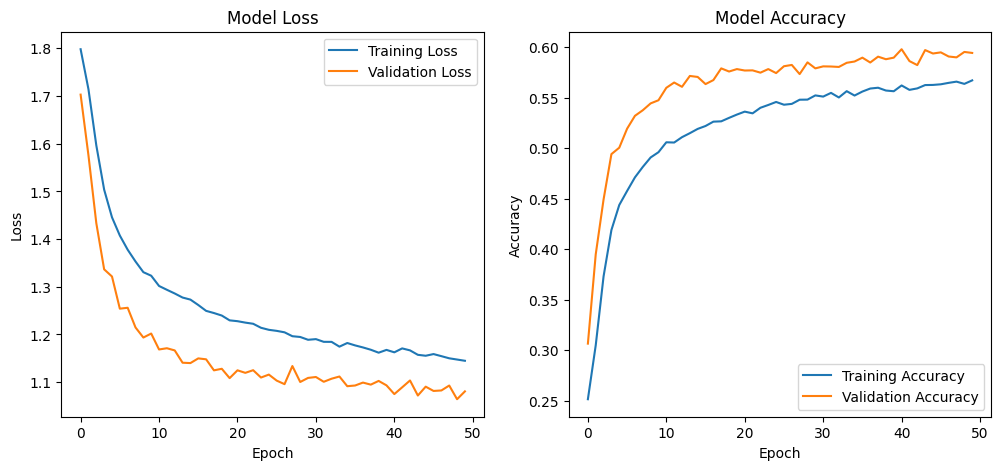

In [30]:
train_acc=history.history["accuracy"]
train_loss=history.history["loss"]
val_loss=history.history["val_loss"]
val_acc=history.history["val_accuracy"]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()